# 回归模型

## Model building ideas：
    Considering the difference of data information in meta_data, some attributes may not have much impact on the final analysis result of the whole model, so some data attributes can be excluded
    ·First, meta_data is used for machine learning and logistic regression is used for classification.
    ·On the basis of classification, the statistical results calculate the feature importance of each feature to judge the most important feature.

### 

In [10]:
from utils import Logger,adjust_learning_rate,CreateLogger,create_cosine_learning_schedule,encode_test_label,set_seed
from model import Single_Modality
from dependency import *
from torch import optim
from torchcontrib.optim import SWA
from dataloader import generate_dataloader
"""dataloader need change √"""
import torch
import numpy as np
import torch.nn.functional as F

### MetaData

In [11]:
from dependency import *
import pandas as pd
pd.read_csv(img_info_path)

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,level_of_diagnostic_difficulty,elevation,location,sex,management,clinic,derm,case_id,notes
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,medium,nodular,abdomen,female,excision,NEL/NEL025.JPG,NEL/Nel026.jpg,NaN,NaN
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,low,palpable,head neck,female,excision,NEL/NEL027.JPG,NEL/Nel028.jpg,NaN,NaN
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,medium,palpable,head neck,female,excision,NEL/Nel032.jpg,NEL/Nel033.jpg,NaN,NaN
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,low,palpable,lower limbs,male,excision,NEL/NEL034.JPG,NEL/Nel035.jpg,NaN,NaN
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,high,palpable,upper limbs,female,excision,NEL/NEL036.JPG,NEL/Nel037.jpg,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,1007,vascular lesion,0,absent,absent,absent,absent,absent,absent,absent,medium,nodular,head neck,male,no further examination,Fhl/Fhl057.jpg,Fhl/Fhl058.jpg,NaN,NaN
1007,1008,vascular lesion,0,absent,absent,absent,absent,absent,absent,absent,high,nodular,abdomen,female,excision,Fhl/Fhl059.jpg,Fhl/Fhl060.jpg,NaN,NaN
1008,1009,vascular lesion,0,absent,absent,absent,absent,absent,absent,absent,high,nodular,head neck,male,clinical follow up,Fil/Fil081.jpg,Fil/Fil082.jpg,NaN,NaN
1009,1010,vascular lesion,0,absent,absent,diffuse regular,absent,absent,absent,absent,low,palpable,upper limbs,male,no further examination,New/newl015.jpg,New/newl016.jpg,NaN,NaN


In [12]:
def encode_label_now(img_info, index_num):#编码标签
    # Encode the diagnositic label
    diagnosis_label = img_info['diagnosis'][index_num]
    for index, label in enumerate(label_list):
        if diagnosis_label in label:
            diagnosis_index = index
            diagnosis_label_index = index + 1
            diagnosis_label_one_hot = to_categorical(diagnosis_index, num_label)
        # print(index_num,diagnosis_index,diagnosis_label,diagnosis_label_one_hot)
        else:
            continue
    #Encode the Seven-point label
    # 1
    pigment_network_label = img_info['pigment_network'][index_num]
    for index, label in enumerate(pigment_network_label_list):
        if pigment_network_label in label:
            pigment_network_index = index
            pigment_network_label_index = index + 1
            pigment_network_label_one_hot = to_categorical(pigment_network_index, num_pigment_network_label)
        else:
            continue
    # 2
    streaks_label = img_info['streaks'][index_num]
    for index, label in enumerate(streaks_label_list):
        if streaks_label in label:
            streaks_index = index
            streaks_label_index = index + 1
            streaks_label_one_hot = to_categorical(streaks_index, num_streaks_label)
        else:
            continue
    # 3
    pigmentation_label = img_info['pigmentation'][index_num]
    for index, label in enumerate(pigmentation_label_list):
        if pigmentation_label in label:
            pigmentation_index = index
            pigmentation_label_index = index + 1
            pigmentation_label_one_hot = to_categorical(pigmentation_index, num_pigmentation_label)
        else:
            continue
    # 4
    regression_structures_label = img_info['regression_structures'][index_num]
    for index, label in enumerate(regression_structures_label_list):
        if regression_structures_label in label:
            regression_structures_index = index
            regression_structures_label_index = index + 1
            regression_structures_label_one_hot = to_categorical(regression_structures_index,
                                                                 num_regression_structures_label)
        else:
            continue
    # 5
    dots_and_globules_label = img_info['dots_and_globules'][index_num]
    for index, label in enumerate(dots_and_globules_label_list):
        if dots_and_globules_label in label:
            dots_and_globules_index = index
            dots_and_globules_label_index = index + 1
            dots_and_globules_label_one_hot = to_categorical(dots_and_globules_index, num_dots_and_globules_label)
        else:
            continue
    # 6
    blue_whitish_veil_label = img_info['blue_whitish_veil'][index_num]
    for index, label in enumerate(blue_whitish_veil_label_list):
        if blue_whitish_veil_label in label:
            blue_whitish_veil_index = index
            blue_whitish_veil_label_index = index + 1
            blue_whitish_veil_label_one_hot = to_categorical(blue_whitish_veil_index, num_blue_whitish_veil_label)
        else:
            continue
    # 7
    vascular_structures_label = img_info['vascular_structures'][index_num]
    for index, label in enumerate(vascular_structures_label_list):
        if vascular_structures_label in label:
            vascular_structures_index = index
            vascular_structures_label_index = index + 1
            vascular_structures_label_one_hot = to_categorical(vascular_structures_index, num_vascular_structures_label)
        else:
            continue

    return np.array([diagnosis_label_index,
                     pigment_network_label_index,
                     streaks_label_index,
                     pigmentation_label_index,
                     regression_structures_label_index,
                     dots_and_globules_label_index,
                     blue_whitish_veil_label_index,
                     vascular_structures_label_index])

In [13]:
def encode_meta_label_now(img_info,index_num):

    level_of_diagnostic_difficulty_label = img_info['level_of_diagnostic_difficulty'][index_num]
    #print(level_of_diagnostic_difficulty_label)
    for index,label in enumerate(level_of_diagnostic_difficulty_label_list):

        if level_of_diagnostic_difficulty_label in label:
            level_of_diagnostic_difficulty_label_index = index
            level_of_diagnostic_difficulty_index = index + 1
            level_of_diagnostic_difficulty_label_one_hot = to_categorical(level_of_diagnostic_difficulty_label_index,num_level_of_diagnostic_difficulty_label_list)
        else:
            continue

    evaluation_label = img_info['elevation'][index_num]
    for index,label in enumerate(evaluation_list):
        if evaluation_label in label:
            evaluation_label_index = index
            evaluation_index = index + 1
            evaluation_label_one_hot = to_categorical(evaluation_label_index,num_evaluation_list)
        else:
            continue

    sex_label = img_info['sex'][index_num]
    for index,label in enumerate(sex_list):
        if sex_label in label:
            sex_label_index = index
            sex_index = index + 1
            sex_label_one_hot = to_categorical(sex_label_index,num_sex_list)
        else:
            continue

    location_label = img_info['location'][index_num]
    for index,label in enumerate(location_list):
        if location_label in label:
            location_label_index = index
            location_index = index + 1
            location_label_one_hot = to_categorical(location_label_index,num_location_list)
        else:
            continue

    management_label = img_info['management'][index_num]
    for index,label in enumerate(management_list):
        if management_label in label:
            management_label_index = index
            management_index = index + 1
            management_label_one_hot = to_categorical(management_label_index,num_management_list)
        else:
            continue

    meta_vector = np.hstack([    #在水平方向上平铺，展开成只有一列
    level_of_diagnostic_difficulty_index,
    evaluation_index,
    location_index,
    sex_index,
    management_index
    ])
    
    return meta_vector

In [14]:
from dependency import *
import numpy as np
from tensorflow.keras.utils import to_categorical
from utils import encode_label,encode_meta_label

#重写导入MetaData的相关函数
class load_metadata:
    def __init__(self):
        self.test_index_df = pd.read_csv(test_index_path)
        self.train_index_df = pd.read_csv(train_index_path)
        self.val_index_df = pd.read_csv(val_index_path)
    
    def load_metadata(self):
        test_index_df = pd.read_csv(test_index_path)
        train_index_df = pd.read_csv(train_index_path)
        val_index_df = pd.read_csv(val_index_path)
        train_index_list = list(train_index_df['indexes'])
        val_index_list = list(val_index_df['indexes'])
        test_index_list = list(test_index_df['indexes'])
        
        train_index_list_1 = train_index_list[0:206]
        train_index_list_2 = train_index_list[206:]
        df = pd.read_csv(img_info_path)
        
        image_dir = source_dir
        img_info = df
        
        
        file_list = train_index_list#-------------------------->>调整训练数据集的数量
        total_img_info = img_info
        metadata = []
        metadata_data = []
        metadata_labels = []
        for file_id in file_list:
            #file_id = file_list[index]
            sub_img_info = total_img_info[file_id:file_id+1]
            clinic_img_path = sub_img_info['clinic']
            dermoscopy_img_path = sub_img_info['derm']
            diagnosis_label = sub_img_info['diagnosis'][file_id]
            for index_label,label in enumerate(label_list):
                if diagnosis_label in label:
                    diagnosis_index = index_label
                    diagnosis_label_one_hot = to_categorical(diagnosis_index,num_label)
                else:
                    continue
            total_label = encode_label_now(sub_img_info,file_id)
            meta_data = encode_meta_label_now(sub_img_info,file_id)
            #return [meta_data,[total_label[0],total_label[1],total_label[2],total_label[3],total_label[4],total_label[5],total_label[6],total_label[7]]]
            metadata.append([meta_data,[total_label[0],total_label[1],total_label[2],total_label[3],total_label[4],total_label[5],total_label[6],total_label[7]]])    
            metadata_data.append(meta_data)
            metadata_labels.append([total_label[0],total_label[1],total_label[2],total_label[3],total_label[4],total_label[5],total_label[6],total_label[7]])
        return metadata,metadata_data,metadata_labels#

#### MetaData的属性：
    1、level_of_diagnostic_difficulty  #3
    2、elevation                #3
    3、sex                    #2
    4、location                 #9
    5、management               #3

#### labels的属性：
    1、diagnosis
    2、pigment_network
    3、streaks
    4、pigmentation
    5、regression_structure
    6、dots_and_globules
    7、blue_whitish_veil
    8、vascular_structures

In [15]:
metadata,metadata_data,metadata_labels = load_metadata().load_metadata()
print(len(metadata))
print(metadata[0])
print(metadata_data[2])
print(metadata_labels[0])

413
[array([3, 3, 1, 2, 1]), [2, 1, 3, 1, 1, 1, 2, 2]]
[2 2 6 1 1]
[2, 1, 3, 1, 1, 1, 2, 2]


## 相关性分析

In [16]:
metadata_labels = np.array(metadata_labels)
#metadata_label_1 = np.expand_dims(metadata_labels,1)
print(metadata_labels.shape)
MetaData = np.concatenate((metadata_data,metadata_labels),axis=1)
df = pd.DataFrame(MetaData,columns=['level_of_diagnostic_difficulty','elevation','location','sex','management',
                                    '1.diagnosis',
                                    '2.pigment_network',
                                    '3.streaks',
                                    '4.pigmentation',
                                    '5.regression_structure',
                                    '6.dots_and_globules',
                                    '7.blue_whitish_veil',
                                    '8.vascular_structures'])
df

(413, 8)


,level_of_diagnostic_difficulty,elevation,location,sex,management,1.diagnosis,2.pigment_network,3.streaks,4.pigmentation,5.regression_structure,6.dots_and_globules,7.blue_whitish_veil,8.vascular_structures
0,3,3,1,2,1,2,1,3,1,1,1,2,2
1,2,3,1,2,1,2,1,1,3,1,3,1,3
2,2,2,6,1,1,2,1,1,1,1,3,2,2
3,2,2,6,2,1,2,1,1,1,1,1,1,2
4,3,2,1,1,1,2,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,2,2,6,2,3,5,3,1,1,1,2,1,1
409,2,2,1,2,3,5,2,1,3,1,1,1,1
410,3,3,2,1,1,4,1,1,2,1,1,1,1
411,1,3,6,1,3,4,1,1,2,1,1,1,1


### 绘制散点图

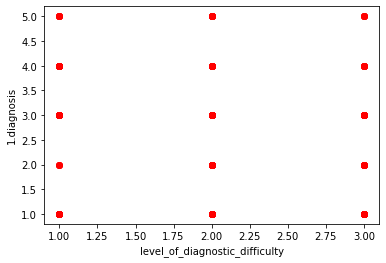

In [203]:
import matplotlib.pyplot as plt
feature_name = 'level_of_diagnostic_difficulty'
label_name = '1.diagnosis'
# 提取特征值
exam_x = df.loc[:,feature_name]
exam_y = df.loc[:,label_name]
plt.scatter(exam_x,exam_y,color='r',label='exam_score')
# 添加坐标标签
plt.xlabel(feature_name)
plt.ylabel(label_name)
#显示图像
plt.show()


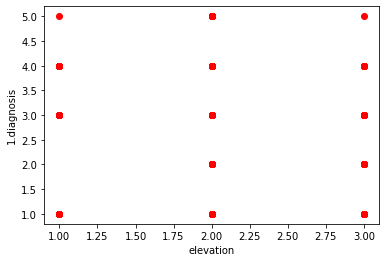

In [204]:
import matplotlib.pyplot as plt
feature_name = 'elevation'
label_name = '1.diagnosis'
# 提取特征值
exam_x = df.loc[:,feature_name]
exam_y = df.loc[:,label_name]
plt.scatter(exam_x,exam_y,color='r',label='exam_score')
# 添加坐标标签
plt.xlabel(feature_name)
plt.ylabel(label_name)
#显示图像
plt.show()


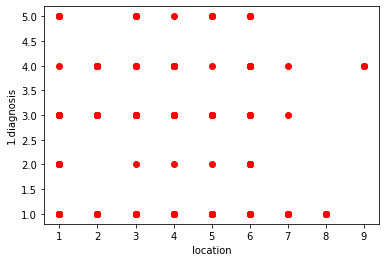

In [205]:
import matplotlib.pyplot as plt
feature_name = 'location'
label_name = '1.diagnosis'
# 提取特征值
exam_x = df.loc[:,feature_name]
exam_y = df.loc[:,label_name]
plt.scatter(exam_x,exam_y,color='r',label='exam_score')
# 添加坐标标签
plt.xlabel(feature_name)
plt.ylabel(label_name)
#显示图像
plt.show()


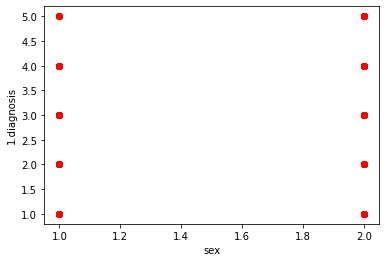

In [206]:
import matplotlib.pyplot as plt
feature_name = 'sex'
label_name = '1.diagnosis'
# 提取特征值
exam_x = df.loc[:,feature_name]
exam_y = df.loc[:,label_name]
plt.scatter(exam_x,exam_y,color='r',label='exam_score')
# 添加坐标标签
plt.xlabel(feature_name)
plt.ylabel(label_name)
#显示图像
plt.show()


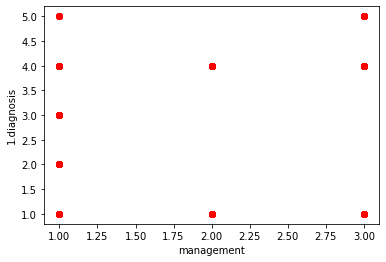

In [207]:
import matplotlib.pyplot as plt
feature_name = 'management'
label_name = '1.diagnosis'
# 提取特征值
exam_x = df.loc[:,feature_name]
exam_y = df.loc[:,label_name]
plt.scatter(exam_x,exam_y,color='r',label='exam_score')
# 添加坐标标签
plt.xlabel(feature_name)
plt.ylabel(label_name)
#显示图像
plt.show()


### 统计每一类中diagnosis的分布情况

·$\textbf{余弦距离：}$
    
    也称为余弦相似度，是用向量空间中两个向量夹角的余弦值作为衡量两个个体间差异的大小的度量。
    余弦值越接近1，就表明夹角越接近0度，也就是两个向量越相似，这就叫"余弦相似性"。
    
·$\textbf{Pearson相关系数：}$
    
    Pearson相关系数(Pearson Correlation Coefficient)是用来衡量两个数据集合是否在一条线上面，它用来衡量定距变量间的线性关系。



In [255]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

In [263]:
row,col = metadata_labels.shape
feature_name = 'level_of_diagnostic_difficulty'
label_name = '1.diagnosis'
print(feature_name+"\t\t"+label_name)
feature_list = set(df.loc[:,feature_name].astype(int))
label_list = set(df.loc[:,label_name].astype(int))
print("feature_list:",feature_list)
print("label_list:",label_list)
counts = np.zeros((len(feature_list),len(label_list)))
for i in range(row):
    counts[int(df.loc[i,feature_name])-1,int(df.loc[i,label_name])-1] += 1
counts_row,counts_col = counts.shape
print(counts)
for i in range(counts_row):
    sum0 = np.sum(counts[i,:])
    counts[i,:] = counts[i,:]/sum0
print("counts:\n",counts)

#------------------------------------>>
print("-"*100)
print("Cosine_similarity:")
s = cosine_similarity(counts)
print(s)
print("Pearson coefficient:")

pearson_r = np.zeros((counts_row,counts_row))
for i in range(counts_row):
    for j in range(i,counts_row):
        s = stats.pearsonr(counts[i,:],counts[j,:])
        pearson_r[i,j] = s[0]
print(pearson_r)

level_of_diagnostic_difficulty		1.diagnosis
feature_list: {1, 2, 3}
label_list: {1, 2, 3, 4, 5}
[[ 91.   3.  41.  18.   5.]
 [103.   9.  20.   8.   7.]
 [ 62.   7.  29.   6.   4.]]
counts:
 [[0.57594937 0.01898734 0.25949367 0.11392405 0.03164557]
 [0.70068027 0.06122449 0.13605442 0.05442177 0.04761905]
 [0.57407407 0.06481481 0.26851852 0.05555556 0.03703704]]
----------------------------------------------------------------------------------------------------
Cosine_similarity:
[[1.         0.96712935 0.99318288]
 [0.96712935 1.         0.97031013]
 [0.99318288 0.97031013 1.        ]]
Pearson coefficient:
[[1.         0.95032722 0.98675987]
 [0.         1.         0.95647116]
 [0.         0.         1.        ]]


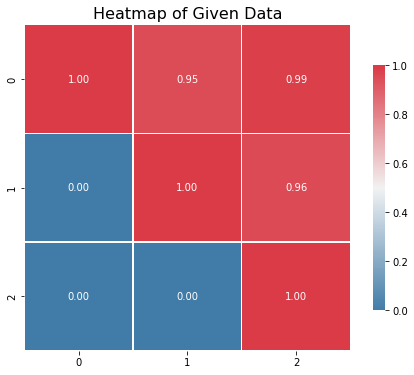

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 你的矩阵数据
data = np.array([[1., 0.95032722, 0.98675987],
                 [0., 1., 0.95647116],
                 [0., 0., 1.]])

# 创建浅蓝和浅红的调色板
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# 绘制热图
plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True, fmt='.2f', cmap=cmap, 
            linewidths=0.5, square=True, cbar_kws={"shrink": .75})

# 设置x轴和y轴的标签
plt.xticks([0.5, 1.5, 2.5])
plt.yticks([0.5, 1.5, 2.5])

# 添加标题
plt.title('Heatmap of Given Data', fontsize=16)

# 显示图像
plt.show()


# chi-square test

### 1. Level_of_diagnostic_difficulty

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
feature_name = 'level_of_diagnostic_difficulty'
label_name = '1.diagnosis'
# Generate crosstabs
contingency_table = pd.crosstab(df[feature_name], df[label_name])

# Calculate chi-square statistics, P-values, expected frequency
chi2, p, dof, expected = chi2_contingency(contingency_table)

# output
print(f"Feature: {feature_name}\t\tLabel: {label_name}")
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Feature: level_of_diagnostic_difficulty		Label: 1.diagnosis
Chi-square statistic: 18.426022214828322
p-value: 0.018249748648941005
Degrees of freedom: 8
Expected frequencies:
 [[97.937046    7.26876513 34.43099274 12.24213075  6.12106538]
 [91.11864407  6.76271186 32.03389831 11.38983051  5.69491525]
 [66.94430993  4.968523   23.53510896  8.36803874  4.18401937]]


### 2. Elevation

In [23]:
feature_name = 'elevation'
label_name = '1.diagnosis'
#
contingency_table = pd.crosstab(df[feature_name], df[label_name])

chi2, p, dof, expected = chi2_contingency(contingency_table)


print(f"Feature: {feature_name}\t\tLabel: {label_name}")
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Feature: elevation		Label: 1.diagnosis
Chi-square statistic: 71.21379188626433
p-value: 2.8160986973475878e-12
Degrees of freedom: 8
Expected frequencies:
 [[114.05326877   8.46489104  40.0968523   14.2566586    7.1283293 ]
 [112.81355932   8.37288136  39.66101695  14.10169492   7.05084746]
 [ 29.13317191   2.1622276   10.24213075   3.64164649   1.82082324]]


### 3. Location

In [25]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
feature_name = 'location'
label_name = '1.diagnosis'
# Generate crosstabs
contingency_table = pd.crosstab(df[feature_name], df[label_name])

# Calculate chi-square statistics, P-values, expected frequency
chi2, p, dof, expected = chi2_contingency(contingency_table)

# output
print(f"Feature: {feature_name}\t\tLabel: {label_name}")
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Feature: location		Label: 1.diagnosis
Chi-square statistic: 130.80595875645565
p-value: 6.668310256549071e-14
Degrees of freedom: 32
Expected frequencies:
 [[69.42372881  5.15254237 24.40677966  8.6779661   4.33898305]
 [46.48910412  3.4503632  16.34382567  5.81113801  2.90556901]
 [36.57142857  2.71428571 12.85714286  4.57142857  2.28571429]
 [37.81113801  2.8062954  13.29297821  4.72639225  2.36319613]
 [26.03389831  1.93220339  9.15254237  3.25423729  1.62711864]
 [20.45520581  1.51815981  7.19128329  2.55690073  1.27845036]
 [14.87651332  1.10411622  5.23002421  1.85956416  0.92978208]
 [ 2.47941889  0.18401937  0.8716707   0.30992736  0.15496368]
 [ 1.85956416  0.13801453  0.65375303  0.23244552  0.11622276]]


### 4. management

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
feature_name = 'management'
label_name = '1.diagnosis'
# Generate crosstabs
contingency_table = pd.crosstab(df[feature_name], df[label_name])

# Calculate chi-square statistics, P-values, expected frequency
chi2, p, dof, expected = chi2_contingency(contingency_table)

# output
print(f"Feature: {feature_name}\t\tLabel: {label_name}")
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Feature: management		Label: 1.diagnosis
Chi-square statistic: 235.1757494634192
p-value: 2.3784697329100598e-46
Degrees of freedom: 8
Expected frequencies:
 [[145.66585956  10.81113801  51.21065375  18.20823245   9.10411622]
 [ 82.44067797   6.11864407  28.98305085  10.30508475   5.15254237]
 [ 27.89346247   2.07021792   9.8062954    3.48668281   1.7433414 ]]


### 5. Sex

In [29]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
feature_name = 'sex'
label_name = '1.diagnosis'
# Generate crosstabs
contingency_table = pd.crosstab(df[feature_name], df[label_name])

# Calculate chi-square statistics, P-values, expected frequency
chi2, p, dof, expected = chi2_contingency(contingency_table)

# output
print(f"Feature: {feature_name}\t\tLabel: {label_name}")
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Feature: sex		Label: 1.diagnosis
Chi-square statistic: 6.421372372901848
p-value: 0.16981247103225994
Degrees of freedom: 4
Expected frequencies:
 [[131.40920097   9.75302663  46.19854722  16.42615012   8.21307506]
 [124.59079903   9.24697337  43.80145278  15.57384988   7.78692494]]


# =======================

In [264]:
row,col = metadata_labels.shape
feature_name = 'elevation'
label_name = '1.diagnosis'
print(feature_name+"\t\t"+label_name)
feature_list = set(df.loc[:,feature_name].astype(int))
label_list = set(df.loc[:,label_name].astype(int))
print("feature_list:",feature_list)
print("label_list:",label_list)
counts = np.zeros((len(feature_list),len(label_list)))
for i in range(row):
    counts[int(df.loc[i,feature_name])-1,int(df.loc[i,label_name])-1] += 1
counts_row,counts_col = counts.shape
print(counts)
for i in range(counts_row):
    sum0 = np.sum(counts[i,:])
    counts[i,:] = counts[i,:]/sum0
print("counts:\n",counts)

#------------------------------------>>
print("-"*100)
print("Cosine_similarity:")
s = cosine_similarity(counts)
print(s)
print("Pearson coefficient:")

pearson_r = np.zeros((counts_row,counts_row))
for i in range(counts_row):
    for j in range(i,counts_row):
        s = stats.pearsonr(counts[i,:],counts[j,:])
        pearson_r[i,j] = s[0]
print(pearson_r)

elevation		1.diagnosis
feature_list: {1, 2, 3}
label_list: {1, 2, 3, 4, 5}
[[143.   0.  25.  15.   1.]
 [ 97.  10.  50.  11.  14.]
 [ 16.   9.  15.   6.   1.]]
counts:
 [[0.77717391 0.         0.13586957 0.08152174 0.00543478]
 [0.53296703 0.05494505 0.27472527 0.06043956 0.07692308]
 [0.34042553 0.19148936 0.31914894 0.12765957 0.0212766 ]]
----------------------------------------------------------------------------------------------------
Cosine_similarity:
[[1.         0.94425773 0.77101126]
 [0.94425773 1.         0.909754  ]
 [0.77101126 0.909754   1.        ]]
Pearson coefficient:
[[1.         0.94519545 0.67784192]
 [0.         1.         0.80406169]
 [0.         0.         1.        ]]


In [265]:
row,col = metadata_labels.shape
feature_name = 'location'
label_name = '1.diagnosis'
print(feature_name+"\t\t"+label_name)
feature_list = set(df.loc[:,feature_name].astype(int))
label_list = set(df.loc[:,label_name].astype(int))
print("feature_list:",feature_list)
print("label_list:",label_list)
counts = np.zeros((len(feature_list),len(label_list)))
for i in range(row):
    counts[int(df.loc[i,feature_name])-1,int(df.loc[i,label_name])-1] += 1
counts_row,counts_col = counts.shape
print(counts)
for i in range(counts_row):
    sum0 = np.sum(counts[i,:])
    counts[i,:] = counts[i,:]/sum0
print("counts:\n",counts)

#------------------------------------>>
print("-"*100)
print("Cosine_similarity:")
s = cosine_similarity(counts)
print(s)
print("Pearson coefficient:")

pearson_r = np.zeros((counts_row,counts_row))
for i in range(counts_row):
    for j in range(i,counts_row):
        s = stats.pearsonr(counts[i,:],counts[j,:])
        pearson_r[i,j] = s[0]
print(pearson_r)

location		1.diagnosis
feature_list: {1, 2, 3, 4, 5, 6, 7, 8, 9}
label_list: {1, 2, 3, 4, 5}
[[78.  8. 21.  1.  4.]
 [39.  0. 28.  8.  0.]
 [40.  1. 10.  4.  4.]
 [35.  1. 16.  8.  1.]
 [29.  1.  8.  1.  3.]
 [ 9.  8.  6.  6.  4.]
 [22.  0.  1.  1.  0.]
 [ 4.  0.  0.  0.  0.]
 [ 0.  0.  0.  3.  0.]]
counts:
 [[0.69642857 0.07142857 0.1875     0.00892857 0.03571429]
 [0.52       0.         0.37333333 0.10666667 0.        ]
 [0.6779661  0.01694915 0.16949153 0.06779661 0.06779661]
 [0.57377049 0.01639344 0.26229508 0.13114754 0.01639344]
 [0.69047619 0.02380952 0.19047619 0.02380952 0.07142857]
 [0.27272727 0.24242424 0.18181818 0.18181818 0.12121212]
 [0.91666667 0.         0.04166667 0.04166667 0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]]
----------------------------------------------------------------------------------------------------
Cosine_similarity:
[[1.         0.91962523 0.99245797 0.96534262 0.

In [274]:
row,col = metadata_labels.shape
feature_name = 'sex'
label_name = '1.diagnosis'
print(feature_name+"\t\t"+label_name)
feature_list = set(df.loc[:,feature_name].astype(int))
label_list = set(df.loc[:,label_name].astype(int))
print("feature_list:",feature_list)
print("label_list:",label_list)
counts = np.zeros((len(feature_list),len(label_list)))
for i in range(row):
    counts[int(df.loc[i,feature_name])-1,int(df.loc[i,label_name])-1] += 1
counts_row,counts_col = counts.shape
print(counts)
for i in range(counts_row):
    sum0 = np.sum(counts[i,:])
    counts[i,:] = counts[i,:]/sum0
print("counts:\n",counts)

#------------------------------------>>
print("-"*100)
print("Cosine_similarity:")
s = cosine_similarity(counts)
print(s)
print("Pearson coefficient:")

pearson_r = np.zeros((counts_row,counts_row))
for i in range(counts_row):
    for j in range(i,counts_row):
        s = stats.pearsonr(counts[i,:],counts[j,:])
        pearson_r[i,j] = s[0]
print(pearson_r)

sex		1.diagnosis
feature_list: {1, 2}
label_list: {1, 2, 3, 4, 5}
[[128.  11.  50.  19.   4.]
 [128.   8.  40.  13.  12.]]
counts:
 [[0.60377358 0.05188679 0.23584906 0.08962264 0.01886792]
 [0.63681592 0.039801   0.19900498 0.06467662 0.05970149]]
----------------------------------------------------------------------------------------------------
Cosine_similarity:
[[1.         0.99482661]
 [0.99482661 1.        ]]
Pearson coefficient:
[[1.         0.99107588]
 [0.         1.        ]]


In [273]:
row,col = metadata_labels.shape
feature_name = 'management'
label_name = '1.diagnosis'
print(feature_name+"\t\t"+label_name)
feature_list = set(df.loc[:,feature_name].astype(int))
label_list = set(df.loc[:,label_name].astype(int))
print("feature_list:",feature_list)
print("label_list:",label_list)
counts = np.zeros((len(feature_list),len(label_list)))
for i in range(row):
    counts[int(df.loc[i,feature_name])-1,int(df.loc[i,label_name])-1] += 1
counts_row,counts_col = counts.shape
print(counts)
for i in range(counts_row):
    sum0 = np.sum(counts[i,:])
    counts[i,:] = counts[i,:]/sum0
print("counts:\n",counts)

#------------------------------------>>
print("-"*100)
print("Cosine_similarity:")
s = cosine_similarity(counts)
print(s)
print("Pearson coefficient:")

pearson_r = np.zeros((counts_row,counts_row))
for i in range(counts_row):
    for j in range(i,counts_row):
        s = stats.pearsonr(counts[i,:],counts[j,:])
        pearson_r[i,j] = s[0]
print(pearson_r)

management		1.diagnosis
feature_list: {1, 2, 3}
label_list: {1, 2, 3, 4, 5}
[[114.  19.  90.   8.   4.]
 [125.   0.   0.   8.   0.]
 [ 17.   0.   0.  16.  12.]]
counts:
 [[0.48510638 0.08085106 0.38297872 0.03404255 0.01702128]
 [0.93984962 0.         0.         0.06015038 0.        ]
 [0.37777778 0.         0.         0.35555556 0.26666667]]
----------------------------------------------------------------------------------------------------
Cosine_similarity:
[[1.         0.77870108 0.54878568]
 [0.77870108 1.         0.68525774]
 [0.54878568 0.68525774 1.        ]]
Pearson coefficient:
[[ 1.00000000e+00  7.14098193e-01 -5.79310885e-04]
 [ 0.00000000e+00  1.00000000e+00  5.68453786e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Conclusion
### After the above analysis steps found that，
### $"sex"$-attribute have virtually no effect on the final prediction.

# **Train several models：

Two groups of comparison models：
    
    1：All Metadata
    
    2：Selected Metadata。